# Relatório EDA e Implementação.

  Os dados disponíveis foram descritos em gráficos dos tipos histograma e boxplot, conforme é possível observar nas células abaixo. No primeiro foi possível analisar a frequência e o tipo de distribuição dos dados, em que quatro variáveis contínuas apresentaram distribuição normal. Já no último, tem-se uma visão de estatísticas descritivas como média e mediana, as quais são medidas de tendência central importantes para a análise de valores discrepantes, por exemplo.
  
 Para as variáveis contínuas air_temperature_k, process_temperature_k, rotational_speed_rpm, torque_nm e tool_wear_min foram observados valores médios que correspondem, respectivamente, a 299,99, 309,99,  1537,41, 40,05, e 108,09. Neste sentido, este gráfico possibilita uma análise inicial de valores discrepantes (possíveis outliers) ao estabelecer valores mínimos e máximos considerando os intervalos entre os quartis.

Para realizar a previsão do tipo de falha, inicialmente foi realizada a remoção das colunas udi e product_id tanto no conjunto de treino quanto no conjunto de testes, que remetiam apenas a dados de identificação. Na sequência, procedeu-se à verificação da existência de valores nulos nos conjuntos, para depois analisar a possível existência de outliers nas variáveis com o auxílio de gráficos boxplot.

Ainda que em duas variáveis tenha se verificado dados fora dos valores máximo e mínimo que o gráfico estabeleceu, considerou-se que não se tratavam de outliers, uma vez que não se tratavam de valores extremamente isolados. No caso da variável categórica type, realizou-se uma binarização dos dados por meio de um processo de one-hot encoding.

O tipo de problema a ser resolvido é de classificação. Deste modo, optou-se pela utilização de um modelo XGBoost, o qual se trata de um modelo baseado em árvores de decisão. Este modelo possui, em geral, melhor desempenho preditivo se comparado a modelos mais simples como a regressão logística. Por outro lado, pode ser um modelo mais complexo de se interpretar.

Foi realizada predição tanto com as variáveis contínuas padronizadas quanto sem a padronização, ainda que modelos baseados em árvore de decisão não apresentam a mesma necessidade de normalização ou padronização dos dados que outros modelos. No entanto, nas duas situações os valores previstos foram iguais.

No que se refere à medida de performance, quando em posse dos rótulos dos dados de teste o ideal é utilizar, além da acurácia, uma medida como a F1 Score, a qual traz agrega informações das medidas de precisão e revocação à análise.


In [1]:
pip install sweetviz --quiet

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from xgboost import XGBClassifier

from sklearn.preprocessing import StandardScaler

import sweetviz as sv

In [3]:
df_train = pd.read_csv('/content/drive/MyDrive/Desafio_Lighthouse/desafio_manutencao_preditiva_treino.csv')

df_test = pd.read_csv('/content/drive/MyDrive/Desafio_Lighthouse/desafio_manutencao_preditiva_teste.csv')

In [4]:
# inicialmente serão removidas as colunas udi e product_id dos conjuntos, pois são apenas identificadores

df_train.drop(columns=['udi', 'product_id'], inplace=True)

df_test.drop(columns=['udi', 'product_id'], inplace=True)

In [5]:
# gerando dashboard externo para EDA inicial do conjunto de treino com a biblioteca sweetviz

report=sv.analyze(df_train)

                                             |          | [  0%]   00:00 -> (? left)

In [6]:
report.show_html('eda_train.html')

Report eda_train.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


In [7]:
# gerando dashboard para comparar conjuntos de treino e teste

report_comp=sv.compare([df_train,'Treino'],[df_test,'Teste']) 
report_comp.show_html('eda_compare.html')

                                             |          | [  0%]   00:00 -> (? left)

Report eda_compare.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


In [8]:
df_train.head()

,type,air_temperature_k,process_temperature_k,rotational_speed_rpm,torque_nm,tool_wear_min,failure_type
0,M,298.1,308.6,1551,42.8,0,No Failure
1,L,298.2,308.7,1408,46.3,3,No Failure
2,L,298.2,308.7,1408,40.0,9,No Failure
3,M,298.1,308.6,1425,41.9,11,No Failure
4,L,298.1,308.6,1558,42.4,14,No Failure


In [9]:
df_test.head()

,type,air_temperature_k,process_temperature_k,rotational_speed_rpm,torque_nm,tool_wear_min
0,L,297.5,308.6,1793,26.7,70
1,L,300.7,310.5,1536,47.4,192
2,L,297.2,308.4,1460,42.1,41
3,L,299.4,309.1,1670,35.9,68
4,L,304.1,313.1,1550,30.9,9


In [10]:
# verificando a existência de valores nulos no conjunto de treino

df_train.isna().sum()

type                     0
air_temperature_k        0
process_temperature_k    0
rotational_speed_rpm     0
torque_nm                0
tool_wear_min            0
failure_type             0
dtype: int64

In [11]:
# verificando a existência de valores nulos no conjunto de teste

df_test.isna().sum()

type                     0
air_temperature_k        0
process_temperature_k    0
rotational_speed_rpm     0
torque_nm                0
tool_wear_min            0
dtype: int64

In [12]:
# apresentando estatísticas descritivas iniciais das variáveis contínuas do conjunto de treino

df_train.describe()

,air_temperature_k,process_temperature_k,rotational_speed_rpm,torque_nm,tool_wear_min
count,6667.000000,6667.000000,6667.000000,6667.000000,6667.000000
mean,299.992515,309.992620,1537.419529,40.058512,108.098095
std,1.994710,1.488101,177.182908,9.950804,63.359915
min,295.300000,305.700000,1168.000000,3.800000,0.000000
25%,298.300000,308.800000,1422.500000,33.200000,54.000000
50%,300.000000,310.000000,1503.000000,40.200000,108.000000
75%,301.500000,311.100000,1612.000000,46.800000,162.000000
max,304.500000,313.800000,2886.000000,76.600000,251.000000


In [13]:
# verificando a existência de valores nulos no conjunto de teste

df_test.isna().sum()

type                     0
air_temperature_k        0
process_temperature_k    0
rotational_speed_rpm     0
torque_nm                0
tool_wear_min            0
dtype: int64

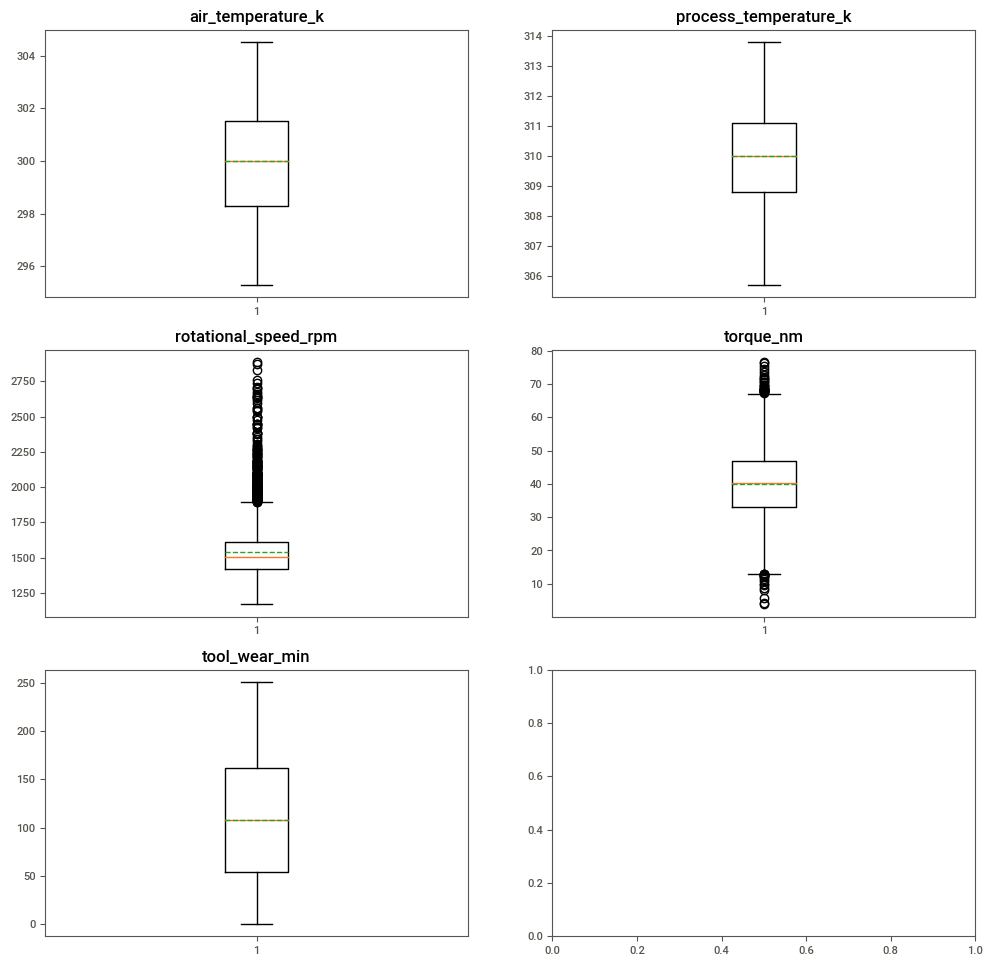

In [14]:
# gerando boxplot das colunas do conjunto de treino para auxiliar na análise exploratória de dados e na verificação da existência de outliers

fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(12, 12), sharey=False)
axs[0, 0].boxplot(df_train['air_temperature_k'], showmeans=True, meanline=True)
axs[0, 0].set_title('air_temperature_k')

axs[0, 1].boxplot(df_train['process_temperature_k'], showmeans=True, meanline=True)
axs[0, 1].set_title('process_temperature_k')

axs[1, 0].boxplot(df_train['rotational_speed_rpm'], showmeans=True, meanline=True)
axs[1, 0].set_title('rotational_speed_rpm')

axs[1, 1].boxplot(df_train['torque_nm'], showmeans=True, meanline=True)
axs[1, 1].set_title('torque_nm')

axs[2, 0].boxplot(df_train['tool_wear_min'], showmeans=True, meanline=True)
axs[2, 0].set_title('tool_wear_min')

plt.show()

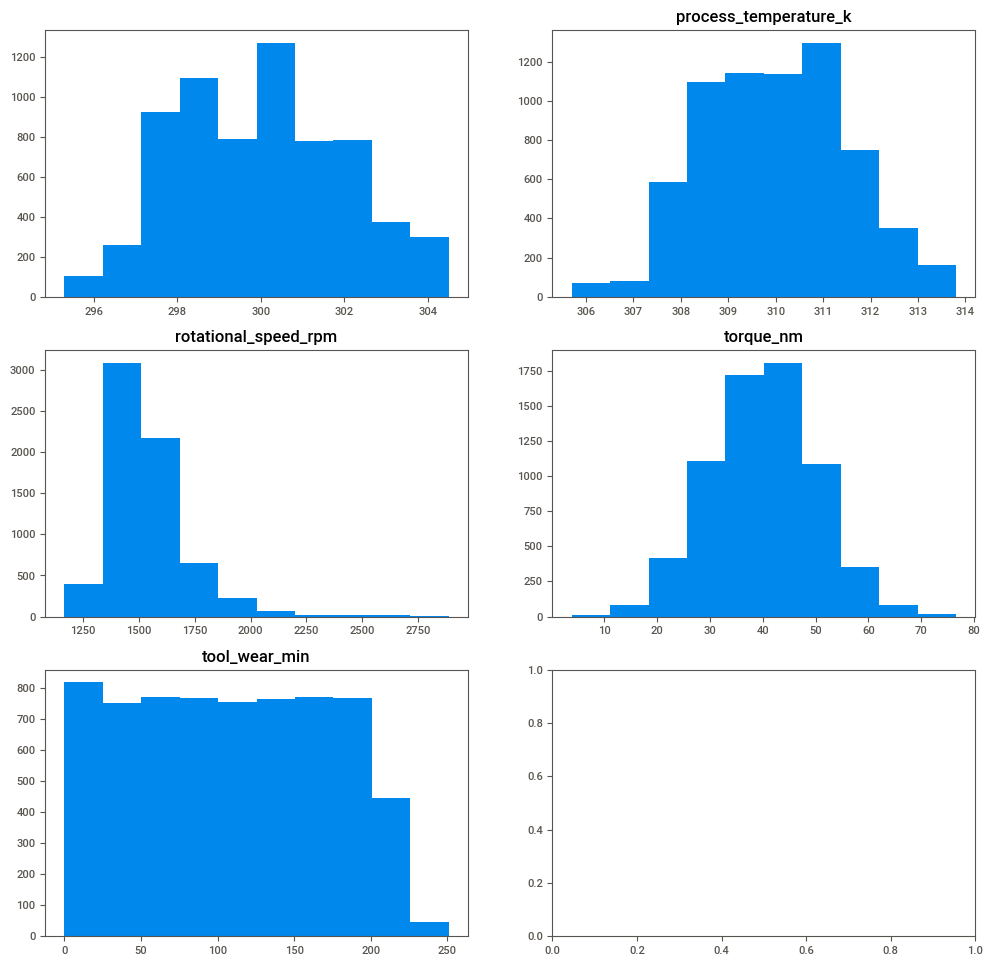

In [15]:
# gerando histograma das colunas do conjunto de treino para auxiliar na verificação do tipo de distribuição dos dados

fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(12, 12), sharey=False)
axs[0, 0].hist(df_train['air_temperature_k'], )
axs[0, 0].set_title, 

axs[0, 1].hist(df_train['process_temperature_k'])
axs[0, 1].set_title('process_temperature_k')

axs[1, 0].hist(df_train['rotational_speed_rpm'])
axs[1, 0].set_title('rotational_speed_rpm')

axs[1, 1].hist(df_train['torque_nm'])
axs[1, 1].set_title('torque_nm')

axs[2, 0].hist(df_train['tool_wear_min'])
axs[2, 0].set_title('tool_wear_min')

plt.show()

In [16]:
# Visto que parte das features possui distribuição normal, será aplicada uma padronização nas variáveis contínuas dos conjuntos,
# com base no conjunto de treino

# sc = StandardScaler()

# df_train[['air_temperature_k',	'process_temperature_k',
#           'rotational_speed_rpm', 'torque_nm', 'tool_wear_min']] = sc.fit_transform(df_train[['air_temperature_k',
#                                                                                            'process_temperature_k', 'rotational_speed_rpm', 'torque_nm',
#                                                                                            'tool_wear_min']])
         
# df_test[['air_temperature_k', 'process_temperature_k',
#         'rotational_speed_rpm', 'torque_nm', 'tool_wear_min']] = sc.transform(df_test[['air_temperature_k',
#                                                                                      'process_temperature_k', 'rotational_speed_rpm', 'torque_nm',
#                                                                                      'tool_wear_min']])

In [17]:
df_train = pd.get_dummies(df_train, columns=['type'])

df_test = pd.get_dummies(df_test, columns=['type'])

In [18]:
df_train.head()

,air_temperature_k,process_temperature_k,rotational_speed_rpm,torque_nm,tool_wear_min,failure_type,type_H,type_L,type_M
0,298.1,308.6,1551,42.8,0,No Failure,0,0,1
1,298.2,308.7,1408,46.3,3,No Failure,0,1,0
2,298.2,308.7,1408,40.0,9,No Failure,0,1,0
3,298.1,308.6,1425,41.9,11,No Failure,0,0,1
4,298.1,308.6,1558,42.4,14,No Failure,0,1,0


In [19]:
df_test.head()

,air_temperature_k,process_temperature_k,rotational_speed_rpm,torque_nm,tool_wear_min,type_H,type_L,type_M
0,297.5,308.6,1793,26.7,70,0,1,0
1,300.7,310.5,1536,47.4,192,0,1,0
2,297.2,308.4,1460,42.1,41,0,1,0
3,299.4,309.1,1670,35.9,68,0,1,0
4,304.1,313.1,1550,30.9,9,0,1,0


In [20]:
modelo_xgb = XGBClassifier(learning_rate=0.1, random_state=0)
modelo_xgb.fit(df_train.drop(columns=['failure_type']), df_train['failure_type'])
preds_xgb = modelo_xgb.predict(df_test)


In [21]:
# np.unique(preds_xgb, return_counts=True)

# (array(['Heat Dissipation Failure', 'No Failure', 'Overstrain Failure',
#         'Power Failure', 'Tool Wear Failure'], dtype=object),
#  array([  33, 3246,   24,   29,    1]))

In [22]:
# Com SC

# np.unique(preds_xgb, return_counts=True)

# (array(['Heat Dissipation Failure', 'No Failure', 'Overstrain Failure',
#         'Power Failure', 'Tool Wear Failure'], dtype=object),
#  array([  33, 3247,   24,   28,    1]))

In [23]:
# Verificou-se que os labels não se alteraram com ou sem a padronização

np.unique(preds_xgb, return_counts=True)

(array(['Heat Dissipation Failure', 'No Failure', 'Overstrain Failure',
        'Power Failure', 'Tool Wear Failure'], dtype=object),
 array([  33, 3247,   24,   28,    1]))

In [24]:
df_test['predictedValues'] = preds_xgb

In [25]:
df_test

,air_temperature_k,process_temperature_k,rotational_speed_rpm,torque_nm,tool_wear_min,type_H,type_L,type_M,predictedValues
0,297.5,308.6,1793,26.7,70,0,1,0,No Failure
1,300.7,310.5,1536,47.4,192,0,1,0,No Failure
2,297.2,308.4,1460,42.1,41,0,1,0,No Failure
3,299.4,309.1,1670,35.9,68,0,1,0,No Failure
4,304.1,313.1,1550,30.9,9,0,1,0,No Failure
...,...,...,...,...,...,...,...,...,...
3328,302.5,311.9,1306,59.7,172,0,1,0,No Failure
3329,300.7,311.0,1413,52.0,91,0,1,0,No Failure
3330,300.8,311.2,1481,38.5,181,0,1,0,No Failure
3331,302.8,312.2,1509,36.5,52,0,1,0,No Failure


In [26]:
df_test['predictedValues'].to_csv('/content/drive/MyDrive/Desafio_Lighthouse/predicted.csv', index=True, index_label='rowNumber')

In [27]:
pip freeze > requirements.txt